In [1]:
import json
import numpy as np
import sys
sys.path.append('../src')
import standard_gwtransf as gw
import os

In [24]:
# SXS catalog data
f_lvcnr = open('/home/sebastian.khan/ligo-nr-data/lvcnr-lfs.json', 'r')
datastore = json.load(f_lvcnr)
f_lvcnr.close()

In [25]:
# Science quality data segments
o1_L1H1_start_times, o1_L1H1_end_times, o1_L1H1_stretches = np.loadtxt('../data/systematics_error_characterisation/o1_L1H1_quality_segments.txt', unpack=True)
o2_L1H1_start_times, o2_L1H1_end_times, o2_L1H1_stretches = np.loadtxt('../data/systematics_error_characterisation/o2_L1H1_quality_segments.txt', unpack=True)
o2_L1H1V1_start_times, o2_L1H1V1_end_times, o2_L1H1V1_stretches = np.loadtxt('../data/systematics_error_characterisation/o2_L1H1V1_quality_segments.txt', unpack=True)

In [35]:
idx = np.random.randint(30, 793) # pick an SXS simulation at random (they are between serial numbers 30 and 793)

name = datastore[idx]['name'].replace(':','_')
path = datastore[idx]['path']

print '... chose:', name, idx

# choosing physical parameters as randomly as possible
M = np.random.uniform(20,160) # total mass chosen random from distribution uniform in [20,160] M_sun
m1, m2 = datastore[idx]['mass1']*M, datastore[idx]['mass2']*M
s1x, s1y, s1z = datastore[idx]['spin1x'], datastore[idx]['spin1y'], datastore[idx]['spin1z']
s2x, s2y, s2z = datastore[idx]['spin2x'], datastore[idx]['spin2y'], datastore[idx]['spin2z']
iota = np.arccos(np.random.uniform(-1., 1.))
pol = np.random.uniform(0., np.pi)
ra = np.random.uniform(0., 2.*np.pi)
dec = np.random.uniform(-np.pi/2., np.pi/2.)
snr = np.random.uniform(500,500)   # choose a random SNR uniformly distributed in [8,25]

print '... chose: M:%.2f, SNR:%.2f'%(M,snr)

... chose: SXS_BBH_0162
... chose: M:60.48, SNR:500.00


In [36]:
# choosing an observing run and detector configuration at random
obs_run = np.random.choice(['o1','o2'])         # choose at random whether the observing run would be O1 or O2
det_config = np.random.choice(['HL','HLV'])     # choose at random whether the detector configuration would be HL or HLV
ifo_map = {'HL':'H1 L1','HLV':'H1 L1 V1'}

if obs_run == 'o1':
    if det_config == 'HL':
        start_times, end_times, stretches = o1_L1H1_start_times, o1_L1H1_end_times, o1_L1H1_stretches
    elif det_config == 'HLV':
        start_times, end_times, stretches = o2_L1H1V1_start_times, o2_L1H1V1_end_times, o2_L1H1V1_stretches
elif obs_run == 'o2':
    start_times, end_times, stretches = o2_L1H1_start_times, o2_L1H1_end_times, o2_L1H1_stretches
    
# choose a random science quality data stretch more than 128 seconds and place the trigger at the centre of that data chunk
idx = np.random.randint(len(stretches))      # choose a random science quality data stretch
if stretches[idx] > 128:                     # ensure it is greater than 128 seconds long
        # choose a 128 second window in that stretch and place the trigger time at the centre
        gps_start_time = np.random.randint(start_times[idx],end_times[idx]-128)
        gps_end_time = int(gps_start_time + 128)
        geocentric_end_time = np.ceil(gps_start_time + (gps_end_time - gps_start_time)/2.)

        print '... chose:', det_config, obs_run, gps_start_time, gps_end_time, geocentric_end_time

        tag = name + obs_run + det_config

... chose: HL o2 1174018914 1174019042 1174018978.0


In [37]:
os.system("pycbc_generate_hwinj --numrel-data /home/sebastian.khan/ligo-nr-data/lvcnr-lfs/%s --approximant NR_hdf5 --order pseudoFourPN --waveform-low-frequency-cutoff 25 --mass1 %f --mass2 %f --spin1x %f --spin1y %f --spin1z %f --spin2x %f --spin2y %f --spin2z %f --inclination %f --polarization %f --ra %f --dec %f --instruments %s --sample-rate H1:16384 L1:16384 V1:16384 --frame-type H1:H1_CLEANED_HOFT_C02 L1:L1_CLEANED_HOFT_C02 V1:V1O2Repro2A --channel-name H1:DCH-CLEAN_STRAIN_C02 L1:DCH-CLEAN_STRAIN_C02 V1:Hrec_hoft_V1O2Repro2A_16384Hz --taper TAPER_START --network-snr %f --psd-low-frequency-cutoff 25.0 --psd-high-frequency-cutoff 1024.0 --psd-estimation median --psd-segment-length 16 --psd-segment-stride 8 --pad-data 8 --geocentric-end-time %d --gps-start-time %d --gps-end-time %d --strain-high-pass 1 --psd-output H1:hwinjcbc_%d_H1_psd.txt L1:hwinjcbc_%d_L1_psd.txt V1:hwinjcbc_%d_V1_psd.txt --tag %s"%(path, m1, m2, s1x, s1y, s1z, s2x, s2y, s2z, iota, pol, ra, dec, ifo_map[det_config], snr, geocentric_end_time, gps_start_time, gps_end_time, geocentric_end_time-6, geocentric_end_time-6, geocentric_end_time-6, tag))

0

In [38]:
os.system('pycbc_insert_frame_hwinj --frame-type H1_CLEANED_HOFT_C02 --channel-name H1:DCH-CLEAN_STRAIN_C02 --gps-start-time %d --gps-end-time %d --pad-data 8 --sample-rate 16384 --hwinj-file %s_%d_H1.txt  --hwinj-start-time %d --ifo H1 --output-file %s_H-H1HWINJ.gwf --strain-high-pass 1'%(gps_start_time,gps_end_time, tag, geocentric_end_time-6, geocentric_end_time-6, tag))

0

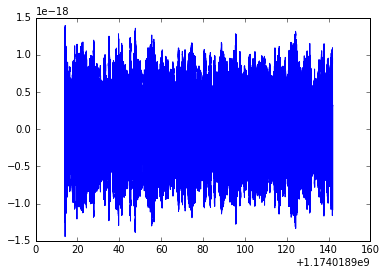

In [42]:
from pycbc import frame as Fr
import matplotlib.pyplot as plt

h1_hoft_hwinj = Fr.read_frame('./SXS_BBH_0162o2HL_H-H1HWINJ.gwf', 'H1:HWINJ_INJECTED', start_time=1174018914, end_time=1174019042)

plt.plot(h1_hoft_hwinj.sample_times, h1_hoft_hwinj)
plt.show()

In [39]:
print idx

1091
